In [2]:
# import dependencies
import sys, os
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy

In [3]:
sys.path.append(os.path.dirname(os.path.dirname("")))
DIRNAME = os.path.dirname("")
df = pd.read_csv(f'{DIRNAME}/output_data/2nd_round_qual/qual_quant_LDA.csv')

In [4]:
df.fillna(value="", inplace=True)
# shuffle the data
df.reset_index(drop=True,inplace=True)
df.head()

,theme,documents,measure
0,2,"So speaking at a local district level, we have...",Theme1_code
1,3,"And I think within the guardrails, the set of ...",Theme1_code
2,4,One of the things that jump off has been the i...,Theme1_code
3,6,we have been involved in the discipline discus...,Theme1_code
4,7,"But furthermore, providers like us had more in...",Theme1_code


## Preprocessing

In [5]:
# clean and tokenize
def initial_clean(text):
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')

def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError:
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))


In [6]:
# clean text and title and create new column "tokenized"

df['tokenized'] = df['documents'].apply(apply_all)

In [7]:
# obtain a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

3686

In [8]:
# choose k and visually inspect the bottom n words of the top k
k = 3500
top_k_words = fdist.most_common(k)
top_k_words[-10:] # n=10 in this case

[('iq', 3),
 ('pastor', 3),
 ('shortsight', 3),
 ('lone', 3),
 ('loneli', 3),
 ('york', 3),
 ('eat', 3),
 ('sacrific', 3),
 ('nonn', 3),
 ('su', 3)]

In [9]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [10]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

In [11]:
# document length (weights)
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 188 
average document length 1045.063829787234 
minimum document length 31 
maximum document length 13474


## LDA

In [12]:
# create a mask of binary values
# use entire corpus to train
msk = np.random.rand(len(df)) < 1

In [13]:
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [14]:
print(len(df),len(train_df),len(test_df))

188 188 0


In [15]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 25 #similar to select for topic modeling
    chunksize = 1
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [16]:
dictionary,corpus,lda = train_lda(train_df)

Time to train LDA model on  188 articles:  0.5634659965833028 min


In [17]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=10, num_words=20)

[(11,
  '0.039*"think" + 0.022*"work" + 0.021*"like" + 0.020*"realli" + 0.018*"educ" + 0.016*"lot" + 0.015*"thing" + 0.014*"way" + 0.013*"want" + 0.012*"polici" + 0.011*"go" + 0.011*"build" + 0.011*"commun" + 0.011*"equiti" + 0.010*"would" + 0.010*"understand" + 0.009*"make" + 0.009*"also" + 0.009*"peopl" + 0.009*"around"'),
 (5,
  '0.000*"gossip" + 0.000*"homeroom" + 0.000*"hoop" + 0.000*"heck" + 0.000*"highli" + 0.000*"graphic" + 0.000*"federalraceandethn" + 0.000*"gosh" + 0.000*"glean" + 0.000*"gi" + 0.000*"gaze" + 0.000*"funder" + 0.000*"formal" + 0.000*"finish" + 0.000*"fingertip" + 0.000*"final" + 0.000*"filipino" + 0.000*"guru" + 0.000*"hole" + 0.000*"fail"'),
 (6,
  '0.000*"gossip" + 0.000*"homeroom" + 0.000*"hoop" + 0.000*"heck" + 0.000*"highli" + 0.000*"graphic" + 0.000*"federalraceandethn" + 0.000*"gosh" + 0.000*"glean" + 0.000*"gi" + 0.000*"gaze" + 0.000*"funder" + 0.000*"formal" + 0.000*"finish" + 0.000*"fingertip" + 0.000*"final" + 0.000*"filipino" + 0.000*"guru" + 0.000*

In [18]:
#inspect individual topics as such
lda.show_topic(topicid=6, topn=20)

[('gossip', 0.00028571428),
 ('homeroom', 0.00028571428),
 ('hoop', 0.00028571428),
 ('heck', 0.00028571428),
 ('highli', 0.00028571428),
 ('graphic', 0.00028571428),
 ('federalraceandethn', 0.00028571428),
 ('gosh', 0.00028571428),
 ('glean', 0.00028571428),
 ('gi', 0.00028571428),
 ('gaze', 0.00028571428),
 ('funder', 0.00028571428),
 ('formal', 0.00028571428),
 ('finish', 0.00028571428),
 ('fingertip', 0.00028571428),
 ('final', 0.00028571428),
 ('filipino', 0.00028571428),
 ('guru', 0.00028571428),
 ('hole', 0.00028571428),
 ('fail', 0.00028571428)]

In [19]:
# select and article at random from train_df
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,3])
print(random_article_index)

70


In [20]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

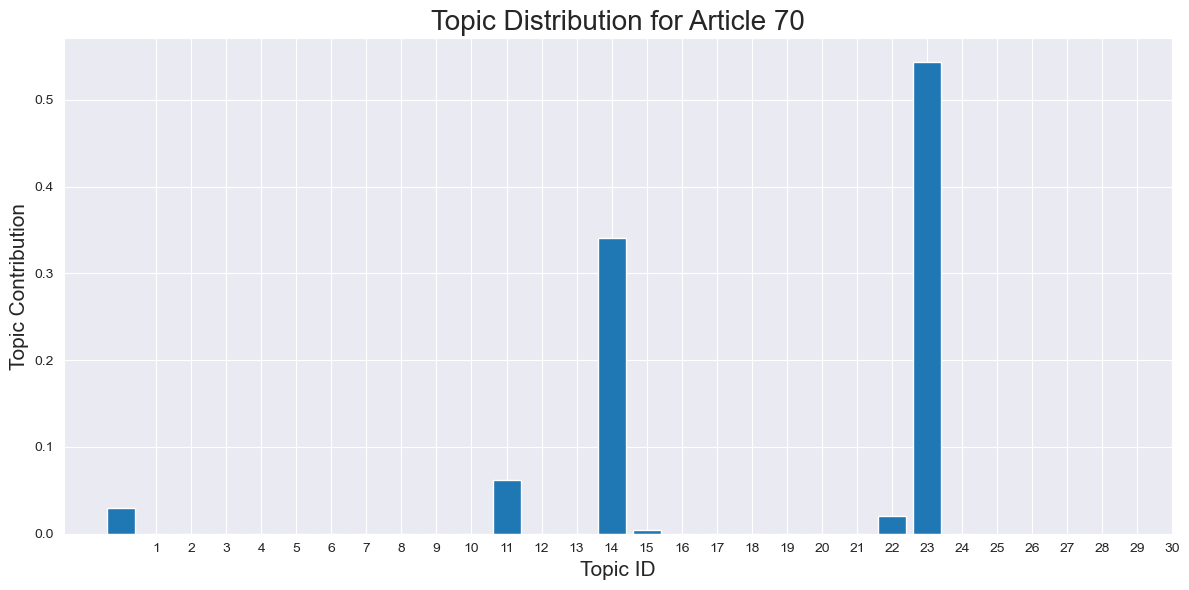

In [21]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(1,30,30))
fig.tight_layout()
plt.show()

In [22]:
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

23 [('go', 0.044370323), ('kid', 0.03938231), ('get', 0.03228795), ('state', 0.02546314), ('school', 0.021622285), ('like', 0.019906642), ('thing', 0.016703622), ('peopl', 0.014838489), ('one', 0.013462475), ('want', 0.013264745)] 

14 [('school', 0.03397838), ('student', 0.032620404), ('support', 0.020133145), ('think', 0.018079275), ('realli', 0.01788333), ('one', 0.015908927), ('look', 0.01281041), ('go', 0.012577007), ('would', 0.01238755), ('system', 0.011683398)] 

11 [('think', 0.039167415), ('work', 0.022105252), ('like', 0.021258494), ('realli', 0.019862562), ('educ', 0.01794331), ('lot', 0.016071115), ('thing', 0.015239546), ('way', 0.01390301), ('want', 0.012830961), ('polici', 0.011833856)] 

0 [('commun', 0.13394971), ('chang', 0.06039883), ('local', 0.047920827), ('board', 0.047072742), ('make', 0.045269728), ('engag', 0.04173916), ('schoolboard', 0.04125445), ('member', 0.04013), ('polit', 0.037279062), ('organ', 0.034008868)] 

22 [('district', 0.051444337), ('fund', 0.